# Federated Learning 101  

In this assignment, you will explore how federated learning handles heterogeneous data sources by working with two different datasets: **MNIST** (handwritten digits) and **SVHN** (Street View House Numbers). You'll implement (1) basic centralized models, (2) federated learning with FedAvg, and compare it with (3) local training without federated learning. 

You will need to start with the provided code to complete 3 tasks.

## Part I: Centralized Machine Learning

In [33]:
# Setup Required libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

### Step 1.1: Load and Preprocess Data
#### To make the problem scnario more challenging, assuming that you can only access a subset of image dataset for each task.
#### i.e. 1000 training samples for MNIST, and 5000 training samples for SVHN dataset.

In [34]:
# For transforming MNIST and SVHN dataset into the same shape
 

transform_mnist = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    # No resize needed for MNIST
])

transform_svhn = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize SVHN to 28x28
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (optional)
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
])



# Load full datasets (you can change the default location as needed)
location = './data'
mnist_full_train = datasets.MNIST(location, train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(location, train=False, transform=transform_mnist)

svhn_full_train = datasets.SVHN(location, split='train', download=True, transform=transform_svhn)
svhn_test = datasets.SVHN(location, split='test', download=True, transform=transform_svhn)

# For MNIST: take the first 1000 samples
mnist_indices = list(range(1000))
mnist_train = Subset(mnist_full_train, mnist_indices)

# For SVHN: take the first 5000 samples
svhn_indices = list(range(5000))
svhn_train = Subset(svhn_full_train, svhn_indices)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


## Step 1.11: This is optional, but help you understand what the two dataset looks like:

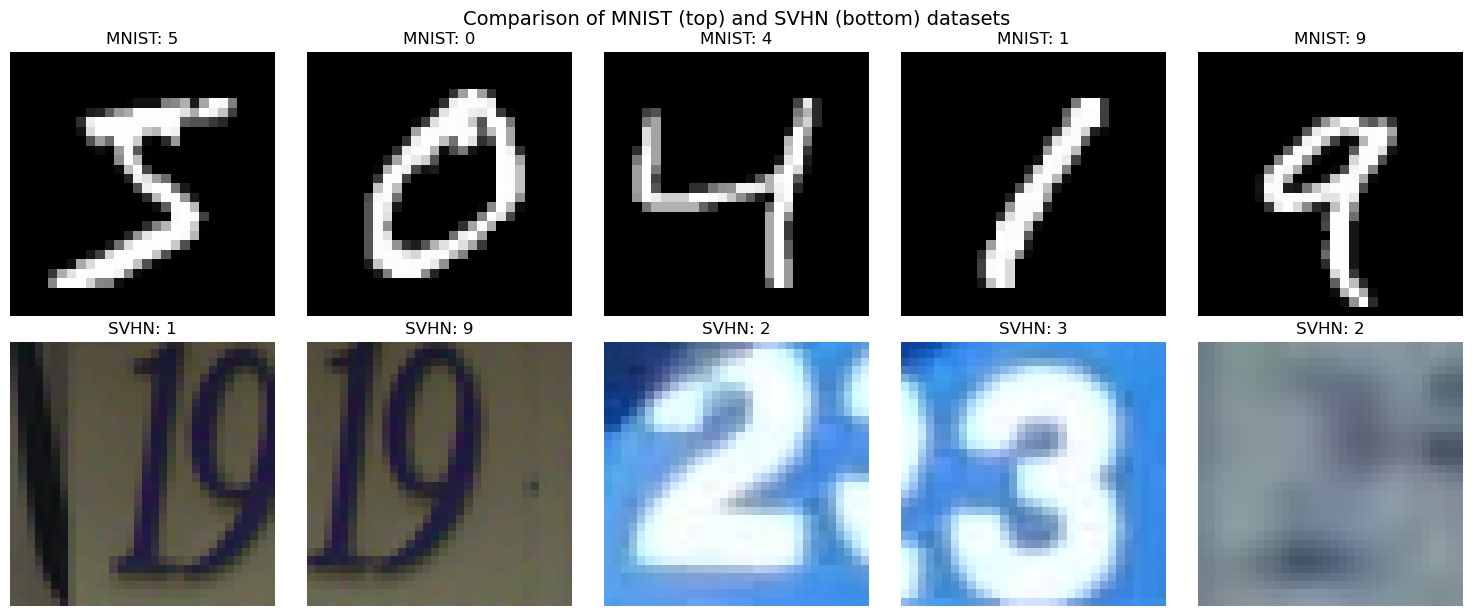

In [35]:
# Create a figure with two rows for MNIST and SVHN
plt.figure(figsize=(15, 6))

 
# Display MNIST images
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(mnist_full_train.data[i], cmap='gray')
    plt.title(f"MNIST: {mnist_full_train.targets[i].item()}")
    plt.axis('off')

 # Display SVHN images
for i in range(5):
    plt.subplot(2, 5, i+6)
    # SVHN in PyTorch has shape (num_examples, channels, height, width)
    # Need to transpose to (height, width, channels) for displaying with matplotlib
    img = np.transpose(svhn_full_train.data[i], (1, 2, 0))
    plt.imshow(img)
    plt.title(f"SVHN: {svhn_full_train.labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Comparison of MNIST (top) and SVHN (bottom) datasets", y=1.02, fontsize=14)
plt.show()


### Step 1.2 Build the Same Neural Network Model Architecture for MNIST and SVHN Dataset. 

In [36]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # For 28x28 input images
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Step 1.3 Train and Evaluate Centralized Models

In [37]:
def train_model(model, train_loader, test_loader, lr=0.001, epochs=10, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Evaluate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    
    return train_losses, test_accuracies

# Assignment Instructions for Part I

1. Use the provided code to load and preprocess both datasets.
2. Instantiate two separate models of the given architecture.
3. Create data loaders for both datasets with batch size **32**.
4. Train one model on MNIST and another on SVHN for 30 epochs.
5. Plot the **training loss** and **test accuracy** curves (over 30 epochs) for both models.
6. Report performance on two datasets, and briefly analyze the differences in model accuracies.
7. For both datset training, use learning rate = 0.001
8. Briefly analyze the differences of model performance between the two datasets, and discuss potential solutions to improve.

1. Dataset Preparation: Use the provided code to load and preprocess both the MNIST and SVHN datasets.
2. Model Instantiation: Initialize two separate models using the given architecture.
3. Data Loaders: Create data loaders for both datasets with a batch size of 32.
4. Training: Train one model on MNIST and another on SVHN for 30 epochs, using a learning rate of 0.001.
5. Performance Evaluation:
+ Plot the training loss and test accuracy curves over 30 epochs for both models.
+ Report the best performance of both models on their respective datasets.

6. Analysis:
+ Compare the differences in model accuracies between the two datasets.
+ Discuss potential challenges and solutions to improve model performance on SVHN 

# Provide your solution below:

In [38]:
# Create data loaders for centralized training
 

In [39]:
# Train centralized models
 

In [40]:

# Plotting results
 

## Part II: Learning with FedAvg 

In this part, we assume a federated learning system with 4 clients, where two clients have access to mnist dataset, and the other two have access to svhn dataset. All client datasets are non-overlapping with each other.

### Step 2.1 Split Data into Client Subsets (To Approximate a Federated Learning Scenario where data are scattered around different clients)

In [41]:
def create_client_data(dataset, num_clients, batch_size=32):
    num_samples = len(dataset)
    samples_per_client = num_samples // num_clients
    
    client_loaders = []
    for i in range(num_clients):
        start_idx = i * samples_per_client
        end_idx = (i + 1) * samples_per_client if i < num_clients - 1 else num_samples
        
        subset = Subset(dataset, range(start_idx, end_idx))
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        client_loaders.append(loader)
    
    return client_loaders

batch_size = 32
# Create client datasets
mnist_client_loaders = create_client_data(mnist_train, num_clients=2, batch_size=batch_size)
svhn_client_loaders = create_client_data(svhn_train, num_clients=2, batch_size=batch_size)
all_client_loaders = mnist_client_loaders + svhn_client_loaders 

# Create  test loaders for FedAvg evaluation 
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size)

### Step 2.2 Build Up FedAvg Training Code

In [42]:
def fedavg_eval(global_model, test_loader):
    # Evaluate global model performance on a testdataset
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = global_model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
    accuracy = 100 * correct / total
    return accuracy

def fedavg_train_one_round(global_model, client_loaders, criterion, lr=0.2, client_epochs=1):
    # Save the current global model weights
    global_weights = copy.deepcopy(global_model.state_dict())
        
    # Client update
    local_weights = []
    for client_idx, loader in enumerate(client_loaders):
        # Create a new model with the global weights
        local_model = DigitClassifier().to(device)
        local_model.load_state_dict(global_weights)
        local_optimizer = optim.SGD(local_model.parameters(), lr=lr)
            
        # Train on local data for 'client_epochs'
        local_model.train()
        epoch_loss = 0.0
            
        for _ in range(client_epochs):
            batch_loss = 0.0
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                local_optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                local_optimizer.step()
                batch_loss += loss.item()
                
            epoch_loss += batch_loss / len(loader)
            print(batch_loss / len(loader))
            
            ## Record loss
            #client_train_losses[client_idx].append(epoch_loss / client_epochs)
            
        # Save the trained weights
        local_weights.append(copy.deepcopy(local_model.state_dict()))
        
    # Update global weights (simple average)
    global_weights = {}
    for key in global_model.state_dict().keys():
        global_weights[key] = torch.stack([local_weights[i][key] for i in range(len(local_weights))]).mean(0)
        
    # Update the global model
    global_model.load_state_dict(global_weights)
    return  


# Assignment Instructions for Part II

1. Federated Learning Setup: Implement the FedAvg algorithm to train a global model using 4 clients over 30 global epochs.
2. Each client will have its own local training data, and a global test set for each task (MNIST and SVHN) is provided in Step 2.1.
3. Local Training: At each global round, perform one local epoch on each client's dataset.
4. Plot the global model's **test accuracy** on MNIST and SVHN over the 30 global training epochs.
5. Set the learning rate to **0.1** for all clients.

## Provide Your Solution Below:

In [43]:
def fedavg_train(client_loaders, mnist_test_loader, svhn_test_loader, epochs=20, lr=0.1, client_epochs=1, device='cpu'):
    # Initialize global model
    global_model = DigitClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    #### COMPLETE THIS FUNCTION DEFINITION ####
    
    
     

In [44]:
# Train with FedAvg
print("\nTraining with FedAvg on heterogeneous clients...")



Training with FedAvg on heterogeneous clients...


In [45]:
# Plotting

# PART III Report localized training performance

# Assignment Instructions for Part III

In this part, we compare the performance of Federated Learning (FedAvg) from Part 2 with localized training, where each client trains a model independently using only its own local data, without participating in federated learning.

1. Implement the lodel model training process for  **4** clients, each with **30** local epochs, reuse the client data defined as **mnist_client_loaders** and **svhn_client_loaders** from Part 2. Do not forget to re-initialize the model instances for each client (to avoid repetitive training).

2. Plot each local client model's **test accuracy** on SVHN and MNIST over time. 
3. For all clients, use learning rate = 0.001, and batch size = 32.

In [46]:
## Provide Your Solution Below

## Comparative Analysis and Discussion:

1. Comparing the performance of FedAvg with Local training, does all clients benefit from federated learning? What could be the reasons? (e.g. from data, model, hyper-paramter perspectives)
2. Comparing the performance of FedAvg with Centralized training, is FedAvg necessarily more advantageous? Why or why not?
3. Discuss what you can do to improve Federated Learning performance given these non-iid client scenarios (This topic will be related to your next homework)

# What to Submit:
1. a jupyter notebook source file 
2. a pdf file with all your jupyter notebook results, including running results, figures, and analysis texts 

## NOTE: 
Please indicate whether or to what extent you have used generative AI tools (such as ChatGPT) to facilitate the completion of this assignment.